## Simulando el Universo a Gran Escala

In [3]:
#Importar librerias necesarias
import numpy as np
import h5py as h5
import matplotlib.pyplot as plt 

In [188]:
# Parametros globales
directorio_figuras = 'figuras/'
G = 1
H0 = 67.66
Omega_M = 0.3111
Omega_L = 0.6999

In [88]:
# Leer las condiciones iniciales
nombre_archivo = 'condiciones_iniciales/0_particulas.h5'
archivo = h5.File( nombre_archivo, 'r' )
redshift_inicial = archivo.attrs['current_z']  # redshift inicial de la simulacion
masa_de_particula = archivo.attrs['particle_mass'] # en M_solar / h
# Posiciones iniciales
pos_x = archivo['pos_x'][...]
pos_y = archivo['pos_y'][...]
pos_z = archivo['pos_z'][...]
# Velocidades iniciales
vel_x = archivo['vel_x'][...]
vel_y = archivo['vel_y'][...]
vel_z = archivo['vel_z'][...]
# Numero de particulas
n_particulas = len(pos_x)
# Terminamos de leer, cerramos el archivo
archivo.close()

In [145]:
# Malla para calcular la densidad
L_dominio = 25000 # tamaño de la simulacion en kpc / h
n_malla  = 64      # numero de celdas por cada lado de la malla
dx = L_dominio / n_malla


In [146]:
def calcular_densidad( pos_x, pos_y, pos_z, masa, n_malla, dx ):
    # Funcion para calcular la densidad en base a la posicion y la masa de las particulas
    
    # Iniciamos la densidad como un array 3-dimensional de tamaño n_malla X n_malla X n_malla
    densidad = np.zeros( [n_malla, n_malla, n_malla] )

    indices_x =  ( pos_x / dx ).astype( int ) 
    indices_y =  ( pos_y / dx ).astype( int ) 
    indices_z =  ( pos_z / dx ).astype( int )
    indices = np.array( [ indices_x, indices_y, indices_z] ).T
    
    # Vamos a contar el numero de particulas en cada celda
    # Por cada particula añadimos 1 en la celda correspondinte 
    # a su posicion.
    for indice in indices:
        densidad[indice[0], indice[1], indice[2]] += 1
    
    # Multiplicamos por la masa de la particula 
    # y dividimos por el volumen de la celda
    densidad *= masa
    densidad /= dx**3
    return densidad

In [147]:
densidad = calcular_densidad( pos_x, pos_y, pos_z, masa_de_particula, n_malla, dx )

In [148]:
def graficar_densidad( densidad, directorio, nombre_figura, L ):
    n = densidad.shape[0]
    projeccion = densidad.sum( axis=0 ) / n 
    log_projeccion = np.log10( projeccion )
    fig = plt.figure(figsize=(5, 5))
    imagen = plt.imshow( log_projeccion, extent=(0, L, 0, L), cmap='inferno' )
    color_bar = plt.colorbar( imagen )
    color_bar.set_label( r'$\log_{10} \,\rho_\mathrm{DM} \,\, [\mathrm{ M_\odot \, kpc^{-3} } ]$' )
    plt.xlabel( r'$x \,\, [ h^{-1} \, \mathrm{Mpc}]$')
    plt.ylabel( r'$y \,\, [ h^{-1} \, \mathrm{Mpc}]$')
    nombre = directorio + nombre_figura
    fig.savefig( nombre, dpi=200 )

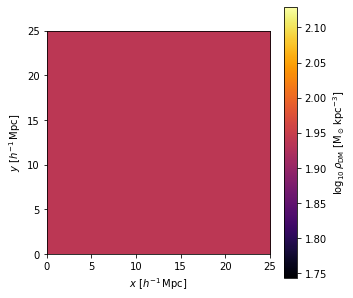

In [149]:
graficar_densidad( densidad, directorio_figuras, 'densidad_0.png', L_dominio//1000 )

In [179]:
def calcular_campo_gravitacional( densidad, factor_escala, G, n_malla, dx  ):

    fuente = 4 * np.pi * G / factor_escala * densidad
    transformada_densidad = np.fft.fftn( fuente )
    k = 2*np.pi*np.fft.fftfreq( n_malla, d=dx )
    k[0] = 1
    kx, ky, kz = np.meshgrid( k, k, k )
    k2 = np.sqrt( kx*kx + ky*ky + kz*kz )
    transformada_potencial =  - transformada_densidad / k2  
    potencial_complejo = np.fft.ifftn( transformada_potencial )

    potencial = np.abs( potencial_complejo )



    transformada_grav_x = 1j * kx * transformada_potencial
    transformada_grav_y = 1j * ky * transformada_potencial
    transformada_grav_z = 1j * kz * transformada_potencial 
    grav_x = np.abs( np.fft.ifftn( transformada_grav_x ) ) 
    grav_y = np.abs( np.fft.ifftn( transformada_grav_y ) ) 
    grav_z = np.abs( np.fft.ifftn( transformada_grav_z ) )
    
    return grav_x, grav_y, grav_z


In [180]:
redshift = redshift_inicial
factor_de_scala = 1 / ( redshift + 1 ) 
grav_x, grav_y, grav_z = calcular_campo_gravitacional( densidad, factor_escala, G, n_malla, dx  )


In [181]:
def calcular_acceleracion( pos_x, pos_y, pos_z, grav_x, grav_y, grav_z, dx ):
    
    n_particulas = len( pos_x )
    
    indices_x =  ( pos_x / dx ).astype( int ) 
    indices_y =  ( pos_y / dx ).astype( int ) 
    indices_z =  ( pos_z / dx ).astype( int )
    indices = np.array( [ indices_x, indices_y, indices_z] ).T
    
    accel_x = np.zeros( n_particulas )
    accel_y = np.zeros( n_particulas )
    accel_z = np.zeros( n_particulas )
    
    for i in range( n_particulas ):
        coords = indices[i]
        ax = grav_x[ coords[0], coords[1], coords[2] ]
        ay = grav_y[ coords[0], coords[1], coords[2] ]
        az = grav_z[ coords[0], coords[1], coords[2] ]
        accel_x[i] = ax
        accel_y[i] = ay
        accel_z[i] = az
        
    return accel_x, accel_y, accel_z
    

In [182]:
accel_x, accel_y, accel_z = calcular_acceleracion( pos_x, pos_y, pos_z, grav_x, grav_y, grav_z, dx )

In [185]:
def actualizar_posiciones( pos_x, pos_y, pos_z, 
                           vel_x, vel_y, vel_z, 
                           a, delta_a, H0, Omega_M, Omega_L ):
    
    H = H0 * np.sqrt( Omega_M/a**3 + Omega_L )
    delta_t = delta_a / ( a * H )
    
    pos_x = pos_x + delta_t * vel_x
    pos_y = pos_y + delta_t * vel_y
    pos_z = pos_z + delta_t * vel_z
    
    return pos_x, pos_y, pos_z
   

In [189]:
delta_a = 1e-2
pos_x, pos_y, pos_z = actualizar_posiciones( pos_x, pos_y, pos_z, 
                      vel_x, vel_y, vel_z, factor_escala, delta_a, H0, Omega_M, Omega_L )